In [1]:
import sys
sys.path.append("../../")
import numpy as np
from tqdm import tqdm
import torch
import json
from TorchInversion.TorchInversion import TorchInversion
from TorchInversion.propagators import Acoustic_Simulation
from TorchInversion.utils import dictToObj,numpy2tensor
from TorchInversion.plots import plot_model,plot_wavelet,plot_dampRegion,plot_observeSystem,wiggle
from TorchInversion.gradient_precond import grad_precond
from TorchInversion.demo import *

In [2]:
save_path = "./data/multiShotMiddle"

# initialize the Project
Project = TorchInversion(save_path=save_path)


2024-01-02 19:57:20,424:logs:INFO:Save To: ./data/multiShotMiddle
2024-01-02 19:57:20,426:logs:INFO:device: cuda:0
2024-01-02 19:57:20,428:logs:INFO:pid: 770933


In [3]:
##################################
# load parameters
##################################
model_config,source,receiver,vel_model = Project.loadConfig()

forward_json = os.path.join(save_path,"config_for.json")
inversion_json = os.path.join(save_path,"config_inv.json")
true_model = json.load(open(forward_json))["vel_model"]
init_model = json.load(open(inversion_json))["vel_model"]
true_v = np.array(true_model["v"])
init_v = np.array(init_model["v"])

adam_v = np.load(os.path.join(save_path,"inv/Adam/inv_v.npz"))["data"][-1]
sd_v = np.load(os.path.join(save_path,"inv/SD/inv_v.npz"))["data"][-1]



In [4]:
def loadbinfloat32(filename):
    ''' Load bin file (float32)
    '''
    fp = open(filename, 'rb')
    obj = np.fromfile(fp, dtype=np.float32)
    fp.close()

    return np.array(obj)

swit_v = loadbinfloat32(os.path.join(save_path,"inv/SWIT/vp-500.bin"))
swit_v = swit_v.reshape(model_config.ny,model_config.nx).T

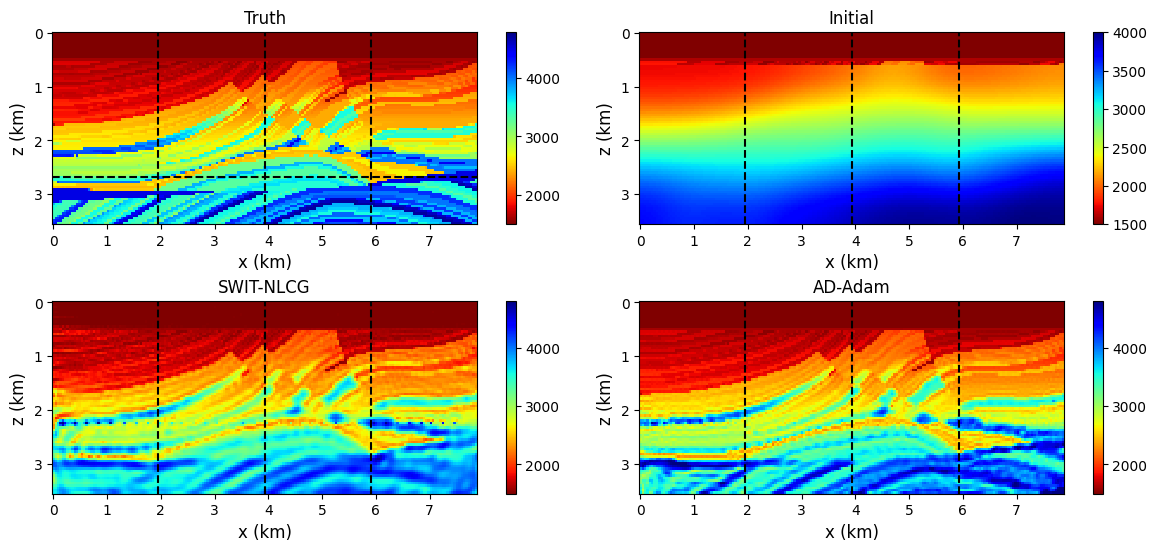

In [5]:
dx,dy = model_config.dx,model_config.dy
nx,ny = model_config.nx,model_config.ny
x = np.arange(0,nx*dx/1000,dx/1000)
y = np.arange(0,ny*dy/1000,dy/1000)
x_mesh, y_mesh = np.meshgrid(y, x)

plt.figure(figsize=(15,6))
plt.subplot(221)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, true_v,cmap="jet_r")
plt.axvline(1*ny//4*dy/1e3,c="k",linestyle="--")
plt.axvline(2*ny//4*dy/1e3,c="k",linestyle="--")
plt.axvline(3*ny//4*dy/1e3,c="k",linestyle="--")
plt.axhline(y=60*dx/1e3,c="k",linestyle="--")
plt.xlabel("x (km)",fontsize=12)
plt.ylabel("z (km)",fontsize=12)
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.title("Truth",fontsize=12)
plt.colorbar(shrink=1)

plt.subplot(222)
plt.pcolormesh(x_mesh-x0, y_mesh, init_v,cmap="jet_r")
plt.axvline(1*ny//4*dy/1e3,c="k",linestyle="--")
plt.axvline(2*ny//4*dy/1e3,c="k",linestyle="--")
plt.axvline(3*ny//4*dy/1e3,c="k",linestyle="--")
plt.xlabel("x (km)",fontsize=12)
plt.ylabel("z (km)",fontsize=12)
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=1)
plt.title("Initial",fontsize=12)

plt.subplot(223)
plt.pcolormesh(x_mesh-x0, y_mesh, swit_v,cmap="jet_r")
plt.axvline(1*ny//4*dy/1e3,c="k",linestyle="--")
plt.axvline(2*ny//4*dy/1e3,c="k",linestyle="--")
plt.axvline(3*ny//4*dy/1e3,c="k",linestyle="--")
plt.xlabel("x (km)",fontsize=12)
plt.ylabel("z (km)",fontsize=12)
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=1)
plt.title("SWIT-NLCG",fontsize=12)

plt.subplot(224)
plt.pcolormesh(x_mesh-x0, y_mesh, adam_v,cmap="jet_r")
plt.axvline(1*ny//4*dy/1e3,c="k",linestyle="--")
plt.axvline(2*ny//4*dy/1e3,c="k",linestyle="--")
plt.axvline(3*ny//4*dy/1e3,c="k",linestyle="--")
plt.xlabel("x (km)",fontsize=12)
plt.ylabel("z (km)",fontsize=12)
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=1)
plt.title("AD-Adam",fontsize=12)

plt.subplots_adjust(hspace=0.4,wspace=0.02)
plt.show()

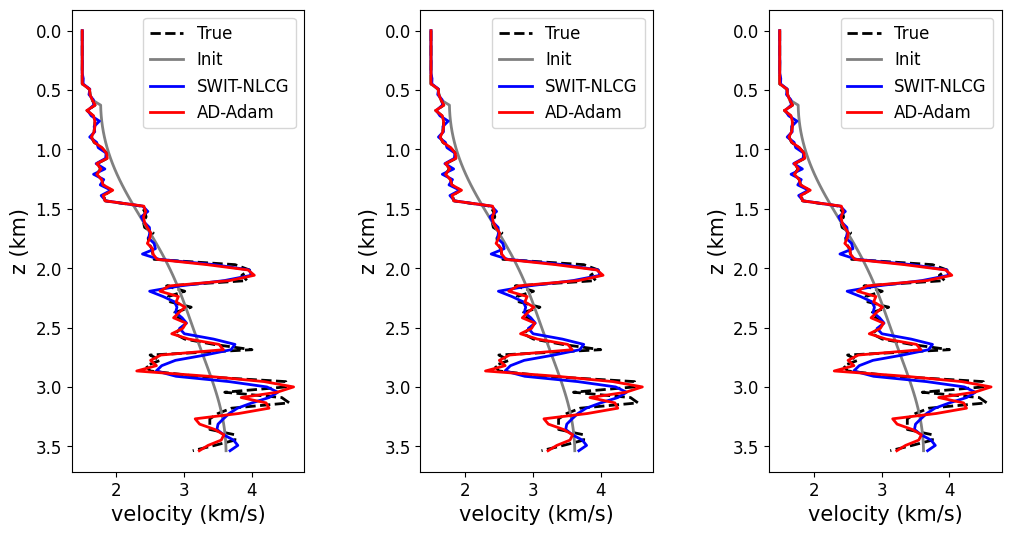

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(true_v[:,ny//4]/1000,  x, c='k',   linewidth=2, linestyle="--" ,label="True")
plt.plot(init_v[:,ny//4]/1000,  x, c='gray',linewidth=2, linestyle="-"  ,label="Init")
plt.plot(swit_v[:,ny//4]/1000,  x, c='b',   linewidth=2, linestyle="-"  ,label="SWIT-NLCG")
plt.plot(adam_v[:,ny//4]/1000,  x, c='r',   linewidth=2, linestyle="-"  ,label="AD-Adam")
plt.xlabel("velocity (km/s)",fontsize=15)
plt.ylabel("z (km)",fontsize=15)
plt.tick_params(labelsize = 12)
plt.gca().invert_yaxis()
plt.legend(fontsize = 12)

plt.subplot(132)
plt.plot(true_v[:,ny//4]/1000,  x, c='k',   linewidth=2, linestyle="--" ,label="True")
plt.plot(init_v[:,ny//4]/1000,  x, c='gray',linewidth=2, linestyle="-"  ,label="Init")
plt.plot(swit_v[:,ny//4]/1000,  x, c='b',   linewidth=2, linestyle="-"  ,label="SWIT-NLCG")
plt.plot(adam_v[:,ny//4]/1000,  x, c='r',   linewidth=2, linestyle="-"  ,label="AD-Adam")
plt.xlabel("velocity (km/s)",fontsize=15)
plt.ylabel("z (km)",fontsize=15)
plt.tick_params(labelsize = 12)
plt.gca().invert_yaxis()
plt.legend(fontsize = 12)

plt.subplot(133)
plt.plot(true_v[:,ny//4]/1000,  x, c='k',   linewidth=2, linestyle="--" ,label="True")
plt.plot(init_v[:,ny//4]/1000,  x, c='gray',linewidth=2, linestyle="-"  ,label="Init")
plt.plot(swit_v[:,ny//4]/1000,  x, c='b',   linewidth=2, linestyle="-"  ,label="SWIT-NLCG")
plt.plot(adam_v[:,ny//4]/1000,  x, c='r',   linewidth=2, linestyle="-"  ,label="AD-Adam")
plt.xlabel("velocity (km/s)",fontsize=15)
plt.ylabel("z (km)",fontsize=15)
plt.tick_params(labelsize = 12)
plt.gca().invert_yaxis()
plt.legend(fontsize = 12)

plt.subplots_adjust(wspace=0.5)
plt.show()

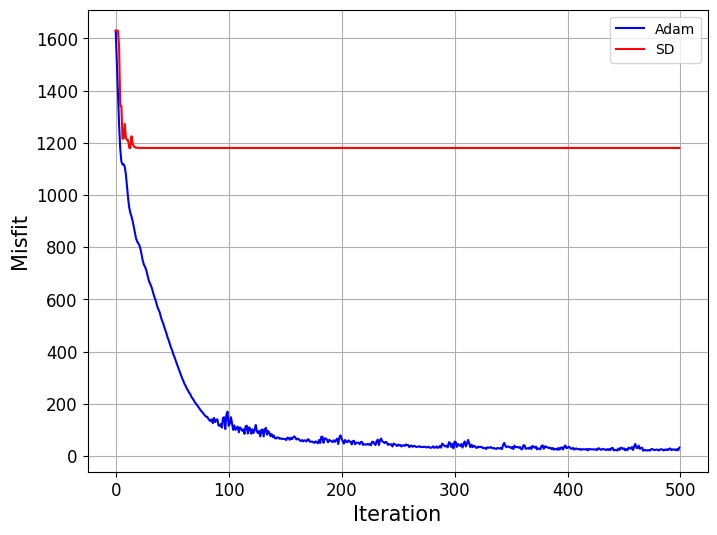

In [7]:
# loss
loss_adam = np.loadtxt(os.path.join(save_path,"inv/Adam/loss.txt"))
loss_sd = np.loadtxt(os.path.join(save_path,"inv/SD/loss.txt"))

plt.figure(figsize=(8,6))
plt.plot(loss_adam,c="b",label="Adam")
plt.plot(loss_sd,c='r',label="SD")
plt.legend()
plt.xlabel("Iteration",fontsize = 15)
plt.ylabel("Misfit",fontsize = 15)
plt.tick_params(labelsize=12)
plt.grid()
plt.show()

In [8]:
loss_adam.min(),loss_sd.min()

(19.84687042236328, 1180.470703125)

In [10]:
def MSE(true_v,inv_v):
    nx,ny = true_v.shape
    return np.sum((true_v-inv_v)**2)/(nx*ny)

layer_grid = 79
print("AD-Adam MSE:\t",MSE(true_v[:layer_grid,:],adam_v[:layer_grid,:]))
print("SWIT-NLCG MSE:\t",MSE(true_v[:layer_grid,:],swit_v[:layer_grid,:]))

AD-Adam MSE:	 26722.85245840634
SWIT-NLCG MSE:	 55591.38543685614
